Date: 09.04.2023 \
Author: Reto Hendry

This script is to visualize the results of the parameter sweeps.

## libraries and functions

In [115]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import statsmodels.api as sm
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", palette="pastel")

# often used variables
tool_list = ["TPOT", "PyCaret", "H2O"]

In [75]:
# function to plot errorbars
def plot_errorbars(x, y, yerr, color, **kwargs):
    plt.errorbar(x, y, yerr=yerr, capsize=2, fmt='none', color=color, **kwargs)

In [76]:
def create_plot(col_var, x_var, x_label, datasets,
                progression_lines=False, save_fig=False):
    """
    Create a plot with the given variables.

    Parameters
    ----------
    col_var : str
        The variable to use for the different subplots.
    x_var : str
        The variable to use for the x-axis.
    x_label : str
        The label for the x-axis.
    progression_lines : bool, optional
        Whether to plot a regression line for the 
        training and test data, by default False.
    datasets : list, optional
        The datasets to use, i.e. [df_tpot, df_pycaret, df_h2o].

    Returns
    -------
    None (plots the figure)
    """

    
    for i, data in enumerate(datasets):
        tools = ["tpot", "pycaret", "h2o"]

        sns.set(style="whitegrid")
        g = sns.FacetGrid(data, col=col_var, height=2.5, aspect=1, col_wrap=3)

        # Training data
        g.map_dataframe(sns.scatterplot, x=x_var, y="CV_Accuracy_(Training)",
                        s=50, color='blue', label="CV Train Accuracy", alpha=0.5)
        g.map_dataframe(plot_errorbars, x=x_var, y="CV_Accuracy_(Training)",
                        yerr="CV_Std_(Training)", color='blue', label="CV Train SD", alpha=0.5)
        
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="CV_Accuracy_(Training)",
                            scatter=False, color='blue', label="CV Train Accuracy\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Test data
        g.map_dataframe(sns.scatterplot, x=x_var, y="Accuracy_(Test)",
                        s=50, color='green', label="Test Accuracy", marker="x", linewidth=1.5)
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="Accuracy_(Test)",
                            scatter=False, color='green', label="Test Accuracy\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Format the plot
        g.set_axis_labels(x_label, "Accuracy [-]")
        g.set(ylim=(0, 1))
        g.add_legend()
        
        # add more ticks to the y-axis
        for ax in g.axes.flat:
            ax.yaxis.set_major_locator(plt.MaxNLocator(10))
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)

        if save_fig:
            plt.savefig(f"../figures/FaceGrid_plot_{tools[i]}.svg", format="svg", bbox_inches="tight", pad_inches=0.05)

        plt.show()

## check for duplicates with same parameters

In [77]:
for tool in tool_list:
    try:
        # analysis only for pycaret
        df_dup_check = pd.read_csv(f"../results/results_check_rep_{tool}.csv")
        df_dup_check["tool"] = tool

        # Remove duplicates ignoring the "id" field
        subset = list(df_dup_check.columns)
        subset.remove("id")
        df_no_dup = df_dup_check.drop_duplicates(subset=subset, keep="first")

        subset = ["component", "resample_cube", "number_of_features", "tool"]
        df_no_param_dup = df_dup_check.drop_duplicates(subset=subset, keep="first")

        print(f"tool: {tool}",
            f"shape of df before dropping duplicates: {df_dup_check.shape}",
            f"shape of df after dropping duplicates: {df_no_dup.shape}",
            f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
            sep="\n")

        no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
        print(f"there are {no_dup_diff} models with the same parameters but different results \n")

    except:
        print(f"!! {tool} not found")
        pass

tool: tpot
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (99, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 9 models with the same parameters but different results 

tool: pycaret
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (90, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 0 models with the same parameters but different results 

tool: h2o
shape of df before dropping duplicates: (176, 10)
shape of df after dropping duplicates: (92, 10)
shape of df after dropping parameter duplicates: (88, 10)
there are 4 models with the same parameters but different results 



Find rows that have the same 'component', 'resample_cube', and 'number_of_features', \
but different values in the other specified columns (ignoring hte "id" field). 

In [78]:
filtered_groups = pd.DataFrame()

for tool in tool_list:
    try:
        # analysis only for pycaret
        df = pd.read_csv(f"../results/results_check_rep_{tool}.csv")

        # Group by the columns where you want to find the same values
        grouped = df.groupby(['component', 'resample_cube', 'number_of_features'])

        # Define a function to check if there are different values in the specified columns
        def has_different_values(group):
            columns_to_check = ['CV_Accuracy_(Training)', 'CV_Std_(Training)', 'Accuracy_(Test)', 
                                'F1_Score_(Test)', 'Precision_Score_(Test)']
            for column in columns_to_check:
                if group[column].nunique() > 1:  # If there's more than one unique value
                    return True
            return False
        
        # sort the filtered groups by component, resample_cube, and number_of_features
        filtered_groups_temp = (grouped
                           .filter(has_different_values)
                           .sort_values(by=['component', 'resample_cube', 'number_of_features'])
        )

        # concat filtered groups of different tools
        filtered_groups = pd.concat([filtered_groups, filtered_groups_temp], axis=0)

    except:
        print(f"!! {tool} not found")
        pass

# Print the results
filtered_groups

id  component  resample_cube  number_of_features   
3    tpot_20230422_173535          1              1                  40  \
93   tpot_20230423_202850          1              1                  40   
9    tpot_20230422_194144          1              1                 100   
99   tpot_20230423_215520          1              1                 100   
57   tpot_20230423_045821          1              6                  80   
147  tpot_20230424_065316          1              6                  80   
64   tpot_20230423_061423          1              7                  50   
154  tpot_20230424_080918          1              7                  50   
73   tpot_20230423_084253          1              8                  40   
163  tpot_20230424_101817          1              8                  40   
76   tpot_20230423_092404          1              8                  70   
166  tpot_20230424_105522          1              8                  70   
78   tpot_20230423_095359          1              8                  90   
168  tpot_20230424_111915          1              8                  90   
79   tpot_20230423_100807          1              8                 100   
169  tpot_20230424_113053          1              8                 100   
88   tpot_20230423_120804          1              9                  90   
178  tpot_20230424_133047          1              9                  90   
10    h2o_20230426_123032          1              1                 210   
21    h2o_20230429_042412          1              1                 210   
28    h2o_20230426_185701          1              3                 130   
39    h2o_20230429_060008          1              3                 130   
50    h2o_20230429_101556          1              5                 130   
61    h2o_20230429_143218          1              5                 130   
72    h2o_20230428_143648          1              7                 130   
83    h2o_20230429_184028          1              7                 130   

     CV_Accuracy_(Training)  CV_Std_(Training)  Accuracy_(Test)   
3                    0.8611             0.1375           0.6111  \
93                   0.8750             0.1559           0.6111   
9                    0.8333             0.1021           0.7778   
99                   0.8194             0.1039           0.7222   
57                   0.8750             0.1021           0.5000   
147                  0.8611             0.1094           0.8333   
64                   0.8472             0.0982           0.5556   
154                  0.8333             0.0833           0.5000   
73                   0.8333             0.0833           0.3889   
163                  0.8472             0.1145           0.4444   
76                   0.8333             0.0833           0.6111   
166                  0.8472             0.0786           0.6111   
78                   0.8194             0.1039           0.5000   
168                  0.7917             0.1318           0.5000   
79                   0.7778             0.1643           0.6667   
169                  0.8056             0.1457           0.6667   
88                   0.8194             0.1039           0.7222   
178                  0.8194             0.1195           0.7222   
10                   0.8582             0.1074           0.7778   
21                   0.8582             0.1074           0.7778   
28                   0.8889             0.0977           0.6111   
39                   0.8651             0.0978           0.8889   
50                   0.8750             0.1250           0.7778   
61                   0.8603             0.0959           0.6111   
72                   0.7778             0.2234           0.6667   
83                   0.7778             0.2052           0.7222   

     F1_Score_(Test)  Precision_Score_(Test)  
3             0.5418                  0.7812  
93            0.6000                  0.6250  
9             0.7778                  0.7778  

## Load results, concatenate, drop duplicates

In [79]:
# create a big dataframe with all the results from all autoML tools
tool_path_list = ["results_param_sweep_tpot.csv", "results_param_sweep_pycaret.csv", "results_param_sweep_h2o.csv"]

df = pd.DataFrame()

for tool in tool_path_list:
    df_i = pd.read_csv(f"../results/{tool}")
    df_i["tool"] = tool.split("_")[-1].split(".")[0]
    df = pd.concat([df_i, df])

In [80]:
# To keep the best performing models, sort the dataframe by the test accuracy
df = df.sort_values('Accuracy_(Test)', ascending=False)
# exclude resample_cube >= 13
df = df.loc[df["resample_cube"] <= 13, :]

# Remove duplicates ignoring the "id" field
subset = list(df.columns)
subset.remove("id")
df_no_dup = df.drop_duplicates(subset=subset, keep="first")

subset = ["component", "resample_cube", "number_of_features", "tool"]
df_no_param_dup = df.drop_duplicates(subset=subset, keep="first")

print(f"shape of df before dropping duplicates: {df.shape}",
      f"shape of df after dropping duplicates: {df_no_dup.shape}",
      f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
      sep="\n")

no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
print(f"there are {no_dup_diff} models with the same parameters but different results")

shape of df before dropping duplicates: (572, 10)
shape of df after dropping duplicates: (455, 10)
shape of df after dropping parameter duplicates: (447, 10)
there are 8 models with the same parameters but different results


## EDA

In [81]:
list(df_no_dup.columns)

['id',
 'component',
 'resample_cube',
 'number_of_features',
 'CV_Accuracy_(Training)',
 'CV_Std_(Training)',
 'Accuracy_(Test)',
 'F1_Score_(Test)',
 'Precision_Score_(Test)',
 'tool']

In [82]:
df_no_param_dup.describe()

component  resample_cube  number_of_features  CV_Accuracy_(Training)   
count      447.0     447.000000          447.000000              447.000000  \
mean         1.0       5.067114          180.469799                0.803024   
std          0.0       3.621060          116.740114                0.064774   
min          1.0       1.000000           10.000000                0.597200   
25%          1.0       2.000000           90.000000                0.763900   
50%          1.0       4.000000          170.000000                0.805600   
75%          1.0       7.000000          270.000000                0.847200   
max          1.0      13.000000          410.000000                0.944400   

       CV_Std_(Training)  Accuracy_(Test)  F1_Score_(Test)   
count         447.000000       447.000000       447.000000  \
mean            0.131884         0.696995         0.681683   
std             0.045945         0.128025         0.144047   
min             0.039300         0.388900         0.333300   
25%             0.102100         0.611100         0.578600   
50%             0.119500         0.666700         0.666700   
75%             0.155900         0.777800         0.775000   
max             0.299700         0.944400         0.944300   

       Precision_Score_(Test)  
count              447.000000  
mean                 0.716794  
std                  0.138750  
min                  0.250000  
25%                  0.625000  
50%                  0.725000  
75%                  0.821400  
max                  0.950000

## Analysis of best parameters

In [83]:
# create single dataframes for every tool
df_tpot = df_no_param_dup.loc[df_no_param_dup["tool"] == "tpot"]
df_h2o = df_no_param_dup.loc[df_no_param_dup["tool"] == "h2o"]
df_pycaret = df_no_param_dup.loc[df_no_param_dup["tool"] == "pycaret"]

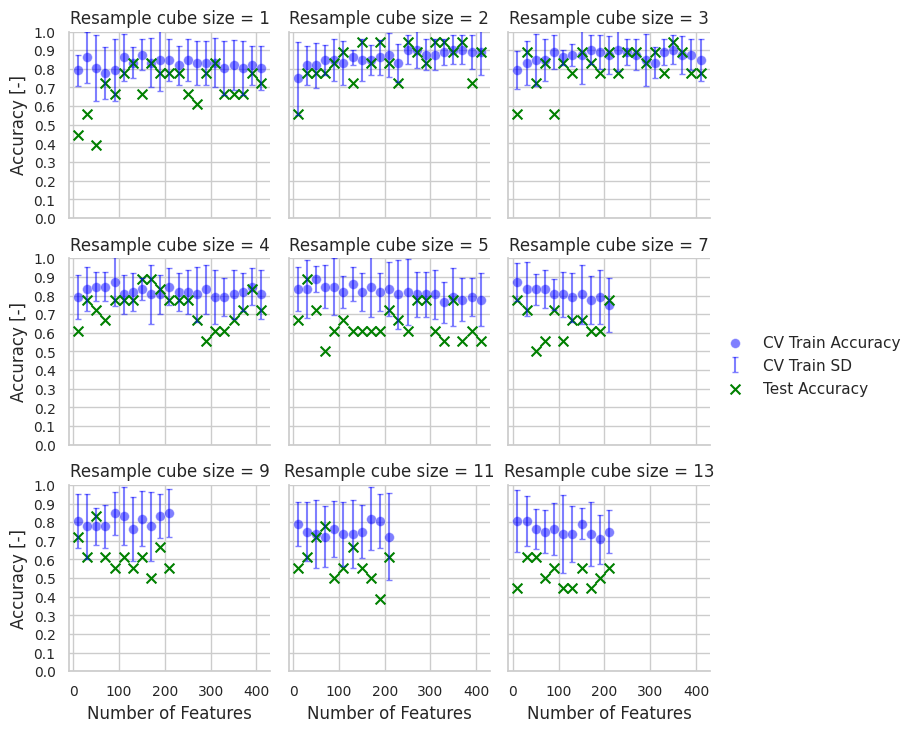

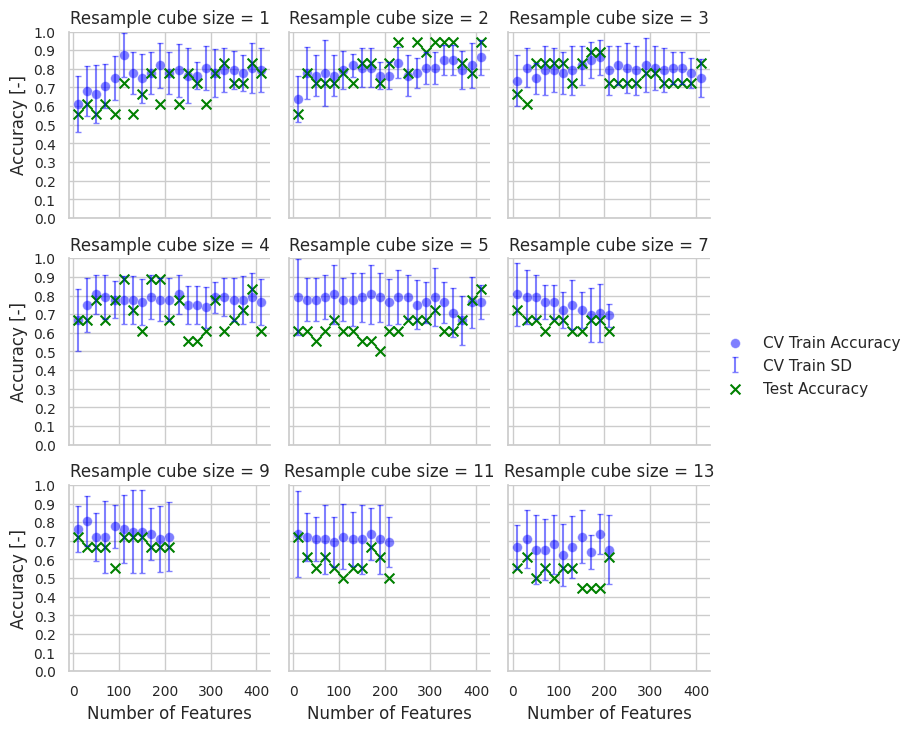

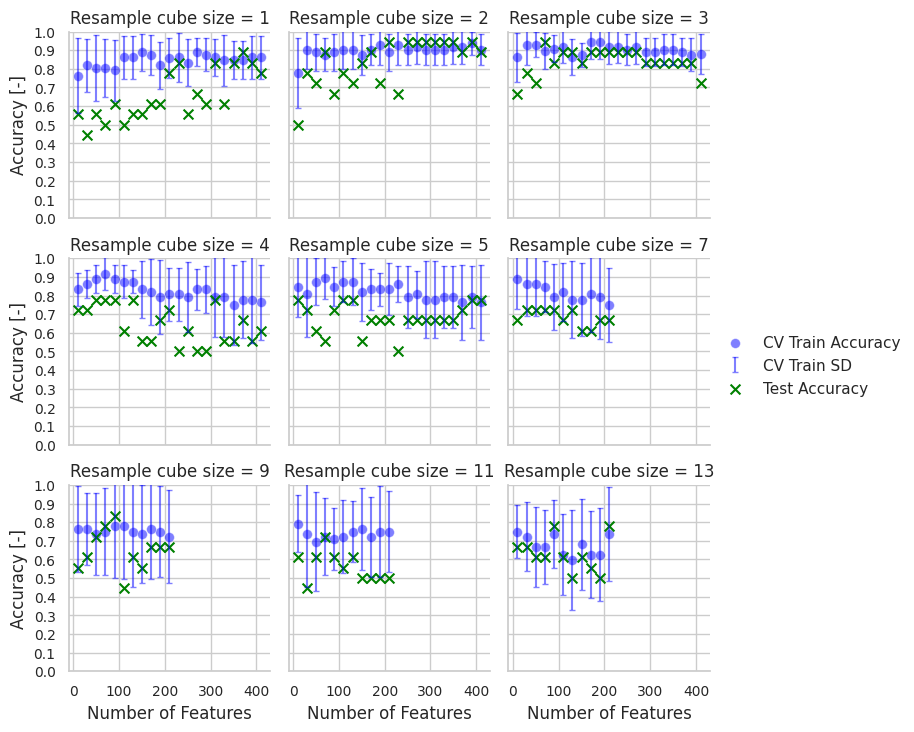

In [84]:
# rename "resample_cube" to "resample cube size"
df_tpot_renamed = df_tpot.rename(columns={"resample_cube": "Resample cube size"})
df_h2o_renamed = df_h2o.rename(columns={"resample_cube": "Resample cube size"})
df_pycaret_renamed = df_pycaret.rename(columns={"resample_cube": "Resample cube size"})

create_plot(col_var="Resample cube size", x_var="number_of_features", 
            x_label="Number of Features", datasets=[df_tpot_renamed, df_pycaret_renamed, df_h2o_renamed],
            save_fig=True)


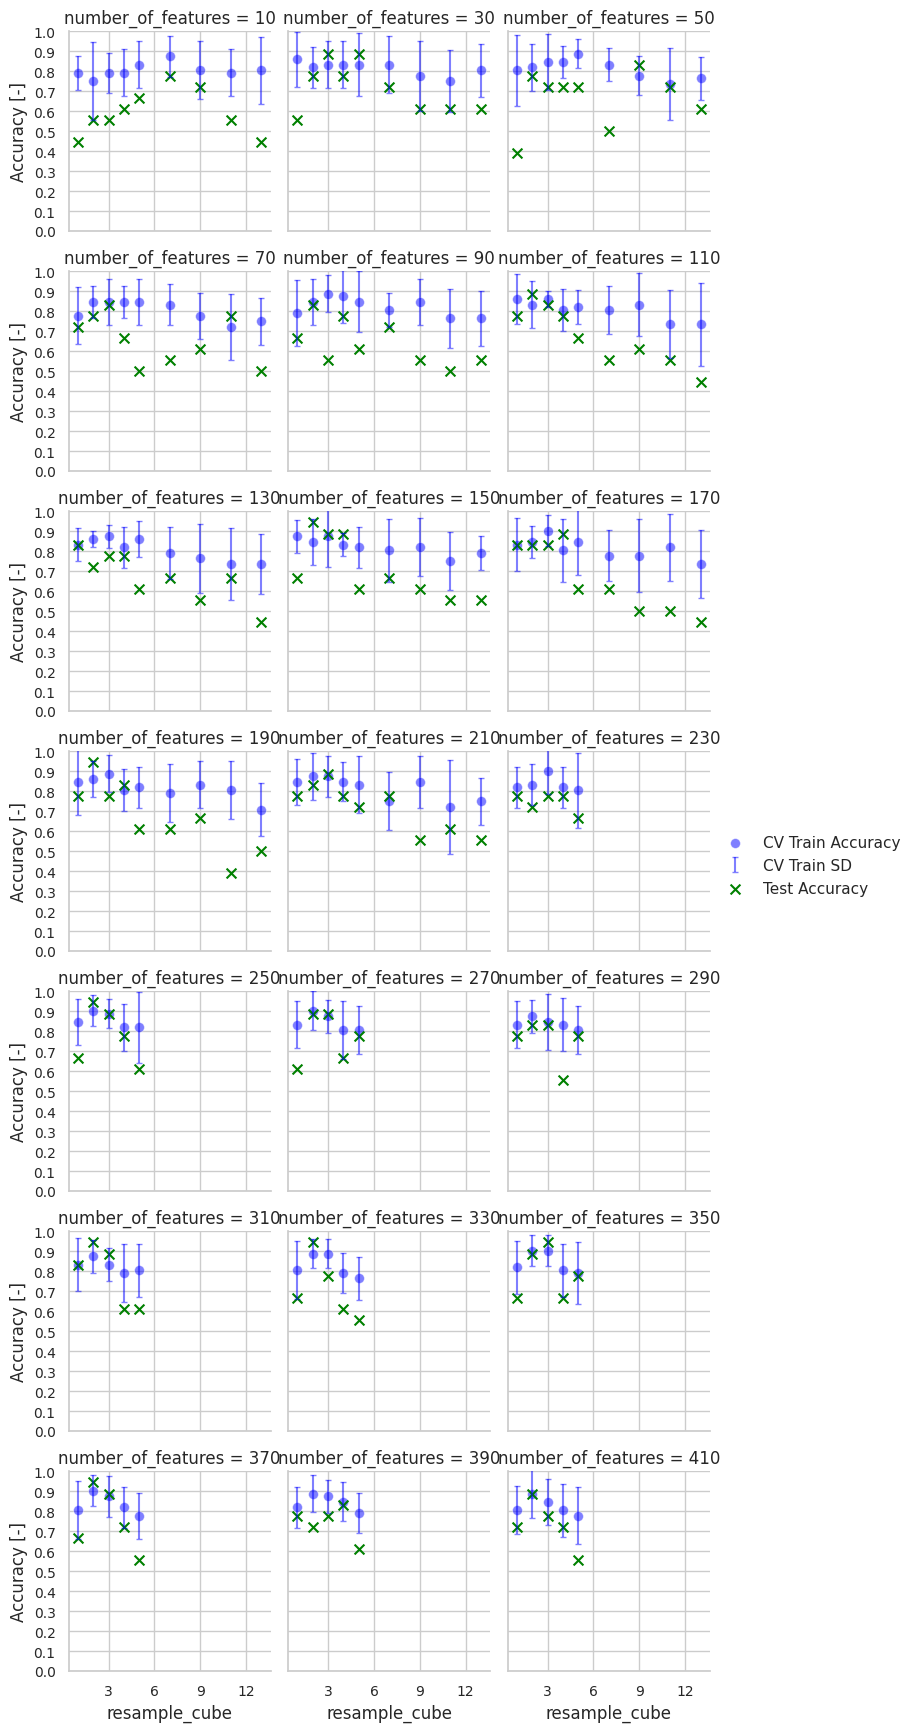

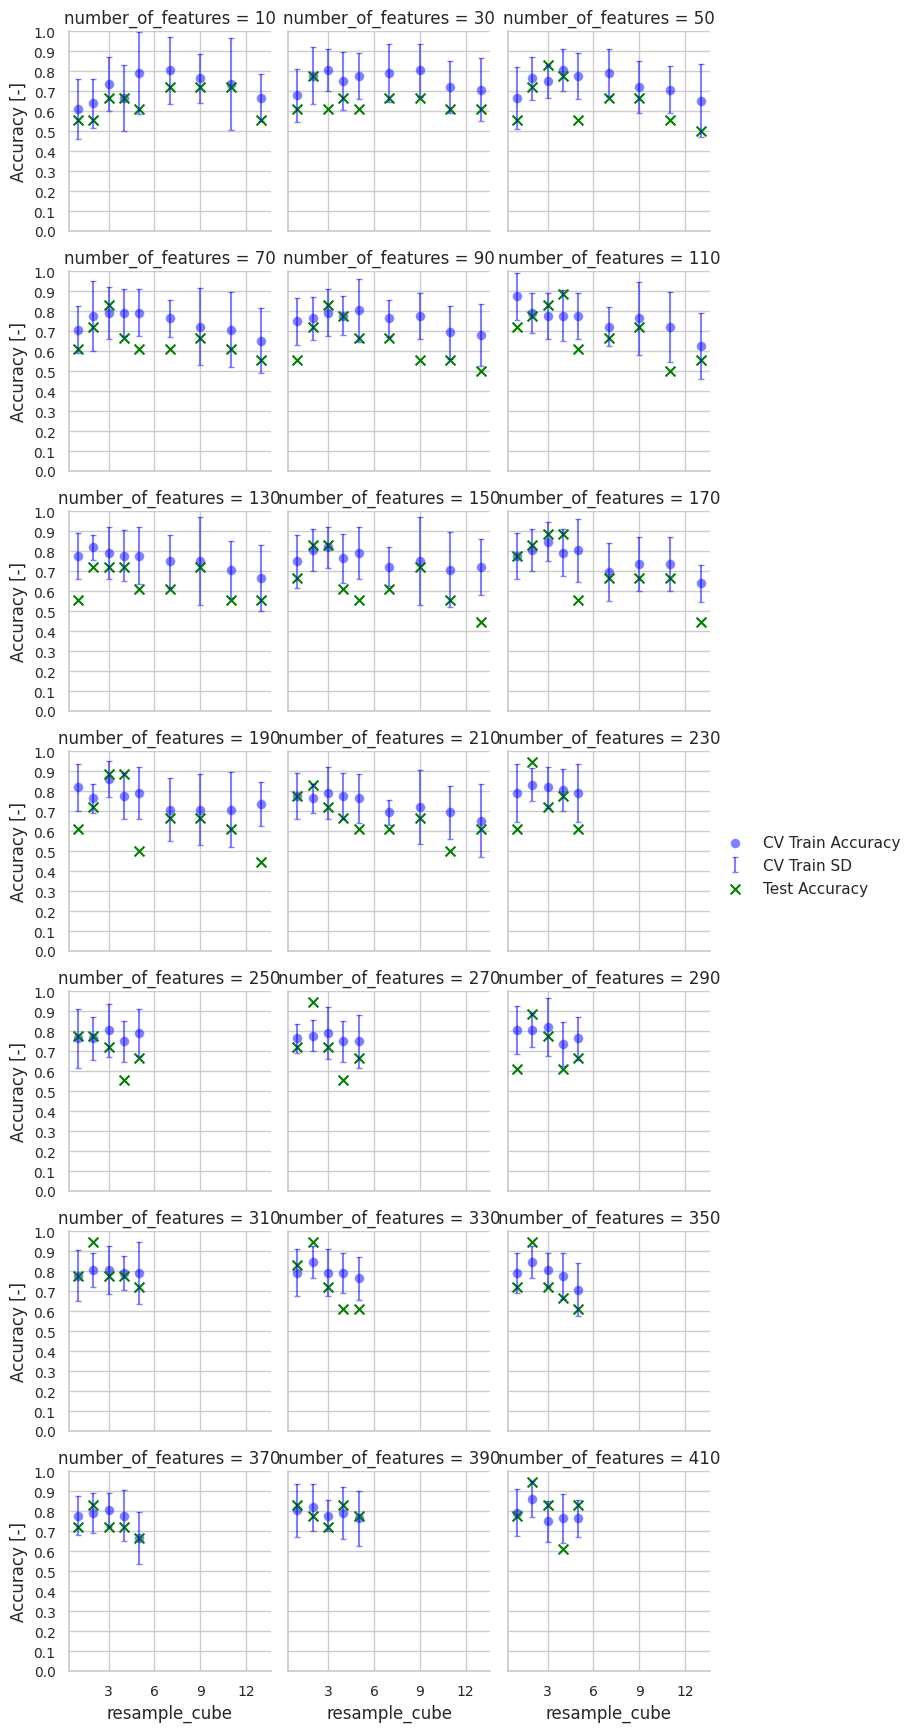

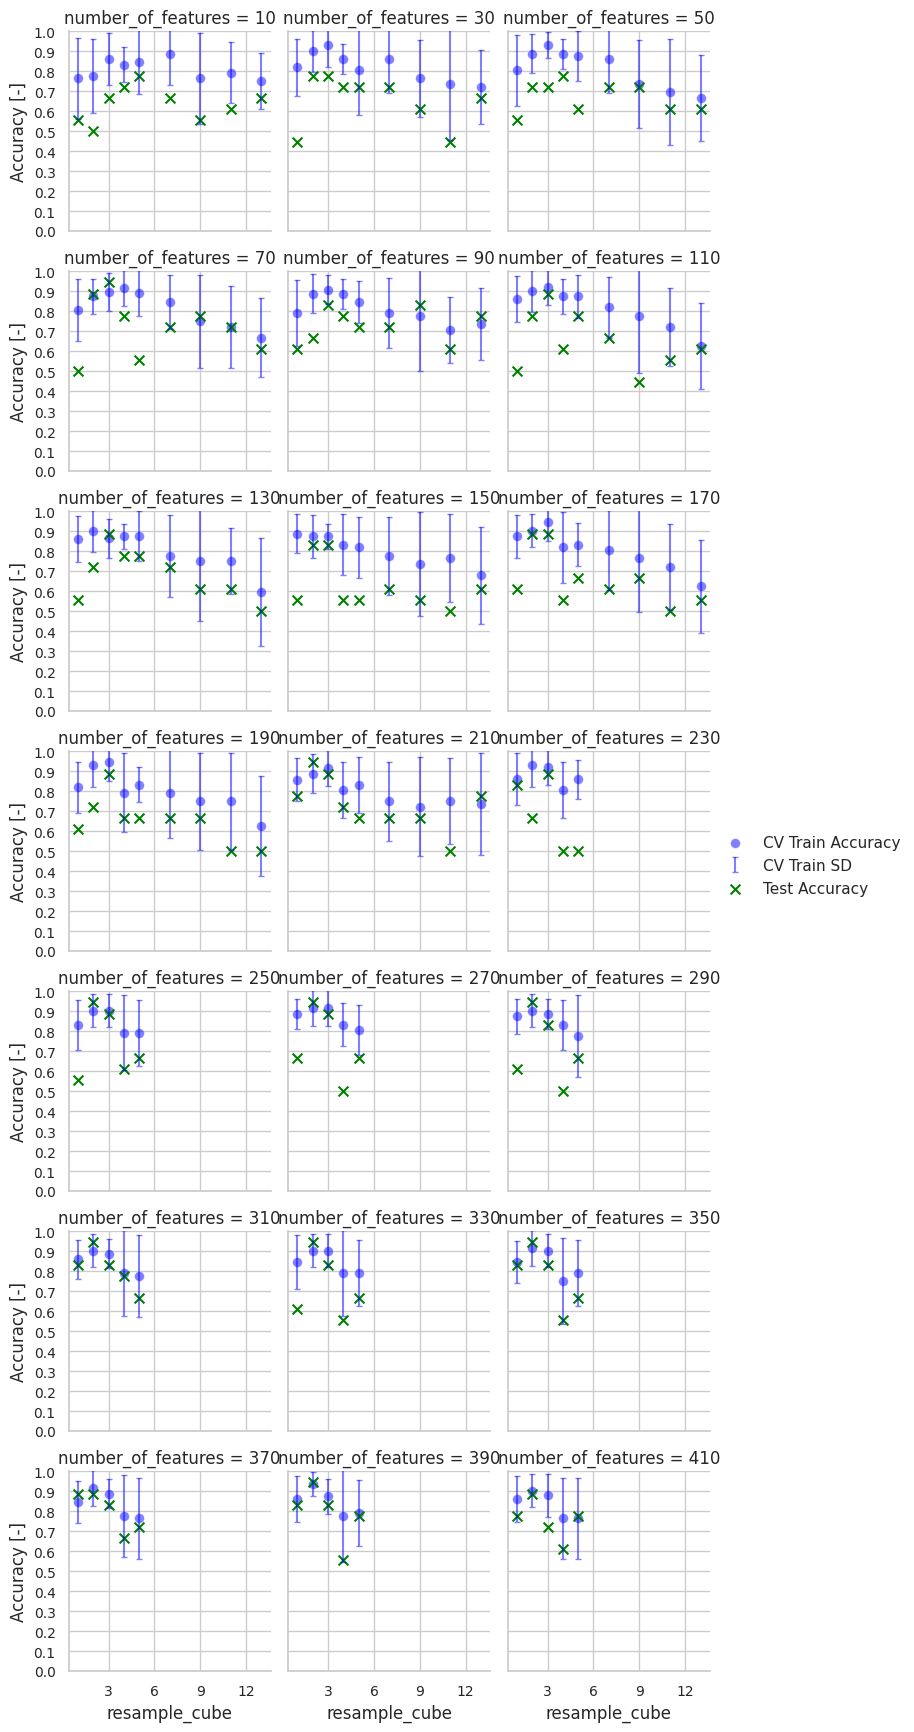

In [85]:
create_plot(col_var="number_of_features", x_var="resample_cube", 
            x_label="resample_cube", datasets=[df_tpot, df_pycaret, df_h2o])


## Heatmap

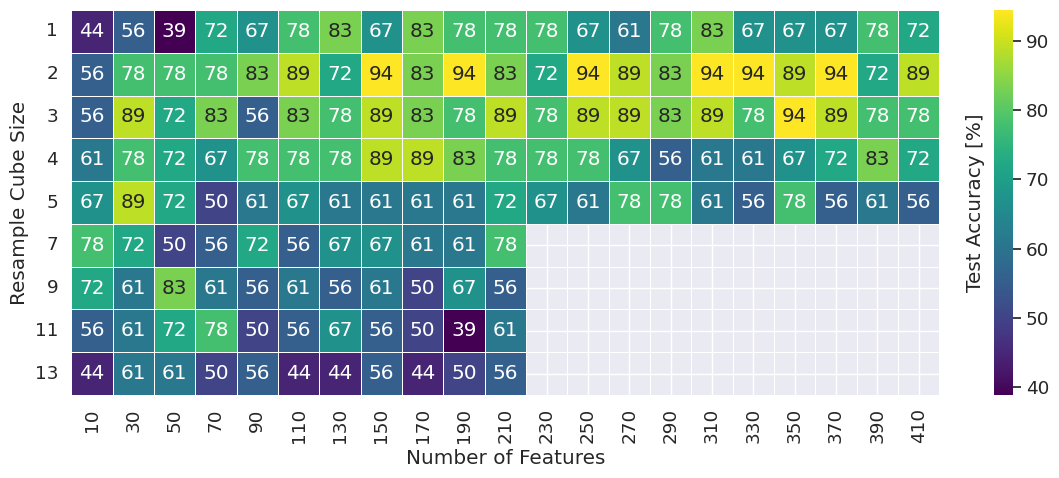

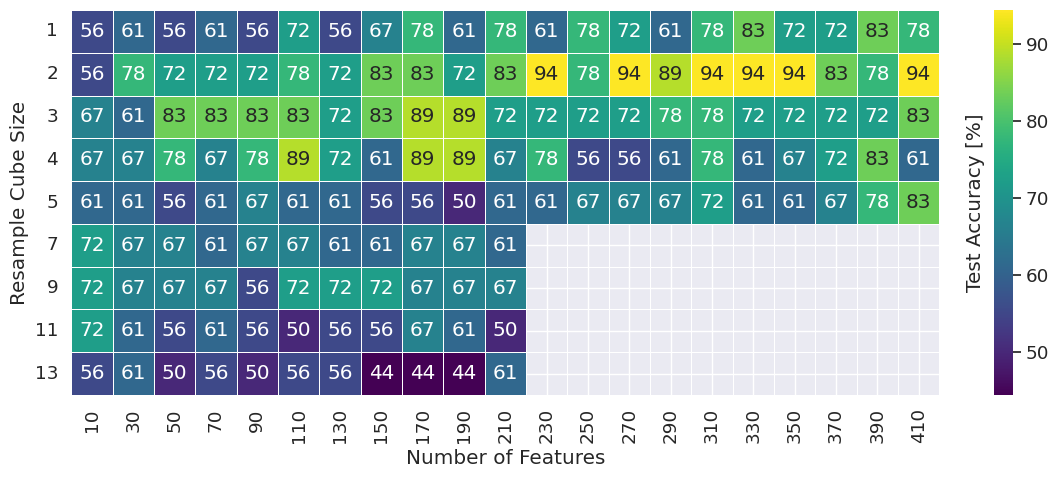

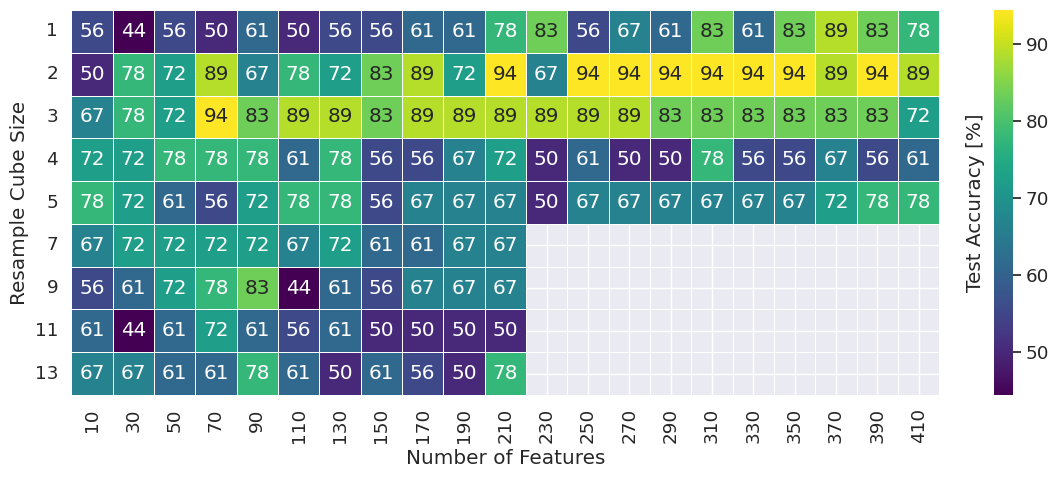

In [86]:
for i, df_in_loop in enumerate([df_tpot.copy(), df_pycaret.copy(), df_h2o.copy()]):
    tools = ["tpot", "pycaret", "h2o"]

    # create a new column where the Accuracy_(Test) are in percentage
    df_in_loop['Accuracy_(Test)_percentage'] = df_in_loop.loc[:, 'Accuracy_(Test)'] * 100

    # Pivot the dataframe
    pivot_df = df_in_loop.pivot(
        index='resample_cube', columns='number_of_features', values='Accuracy_(Test)_percentage'
    )

    # Create the heatmap
    plt.figure(figsize=(14, 5))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.0f', linewidths=.5)
    # ax.set_title(f'Heatmap of Test Accuracy with {tool_list[i]}')

    # Set labels
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Resample Cube Size')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Test Accuracy [%]', rotation=90, labelpad=-60)

    # rotate the x-axis labels by 90 degrees
    plt.xticks(rotation=90)
    
    # plt.savefig(f"../figures/heatmap_{tools[i]}.svg", format="svg", bbox_inches="tight", pad_inches=0.05)
    plt.savefig(f"../figures/heatmap_{tools[i]}.svg", format="svg", bbox_inches="tight", pad_inches=0.05)

    # Show the plot
    plt.show()

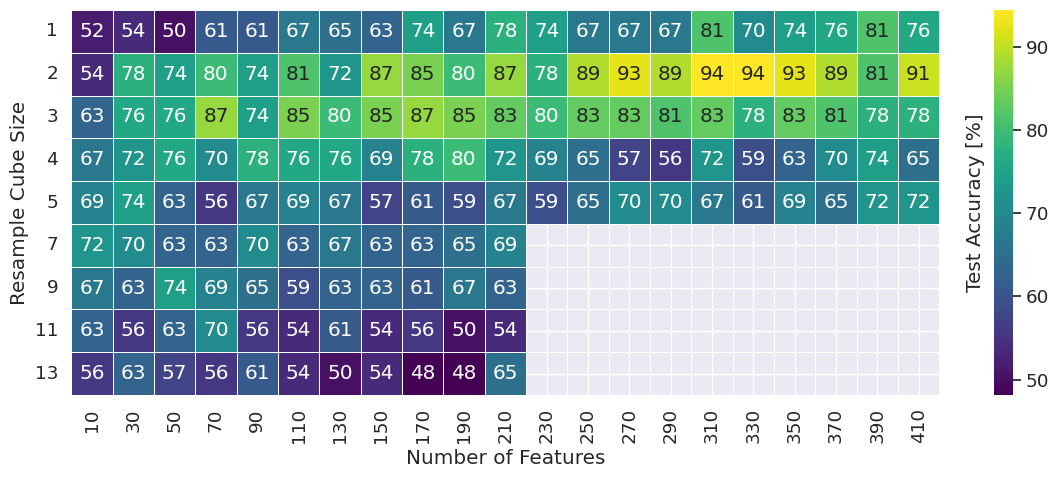

In [87]:
# Group by parameters and compute mean of 'Accuracy_(Test)'
df_grouped = df_no_param_dup.groupby(['component', 'resample_cube', 'number_of_features'])['Accuracy_(Test)'].mean()

# Reset index to return DataFrame instead of Series
df_grouped = df_grouped.reset_index()

# create a new column where the Accuracy_(Test) are in percentage
df_grouped['mean_Accuracy_(Test)_percentage'] = df_grouped['Accuracy_(Test)'] * 100

# Pivot the dataframe
pivot_df = df_grouped.pivot(
    index='resample_cube', columns='number_of_features', values='mean_Accuracy_(Test)_percentage'
)

# Create the heatmap
plt.figure(figsize=(14, 5))
sns.set(font_scale=1.2)
ax = sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.0f', linewidths=.5)
# ax.set_title(f'Heatmap of mean Test Accuracy of all tools')

# Set labels
ax.set_xlabel('Number of Features')
ax.set_ylabel('Resample Cube Size')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.set_label('Test Accuracy [%]', rotation=90, labelpad=-60)

# rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.savefig(f"../figures/heatmap_mean.svg", format="svg", bbox_inches="tight", pad_inches=0.05)

# Show the plot
plt.show()


## comparison of autpML tools for best resample cubes

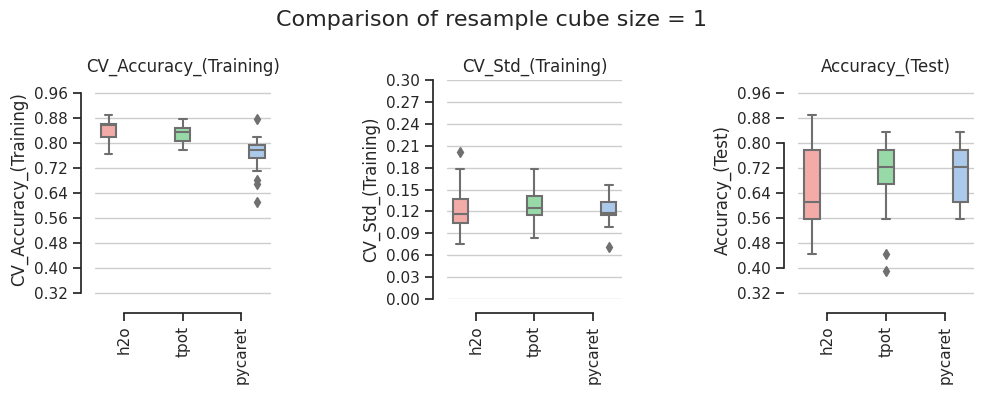

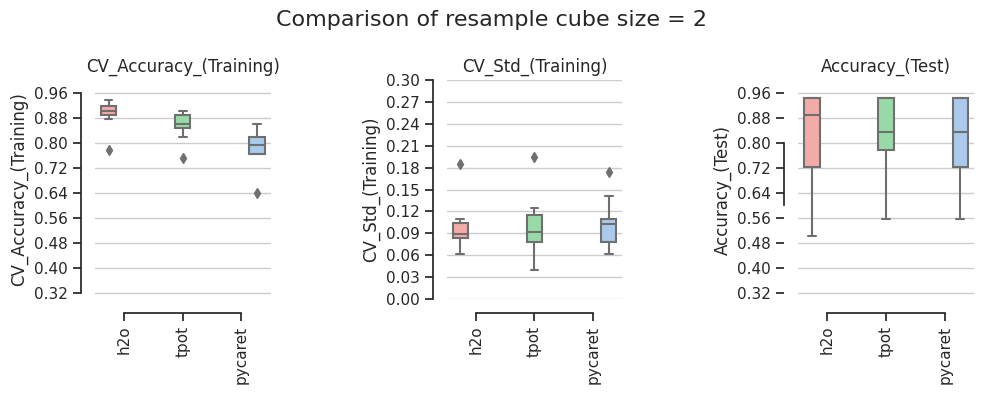

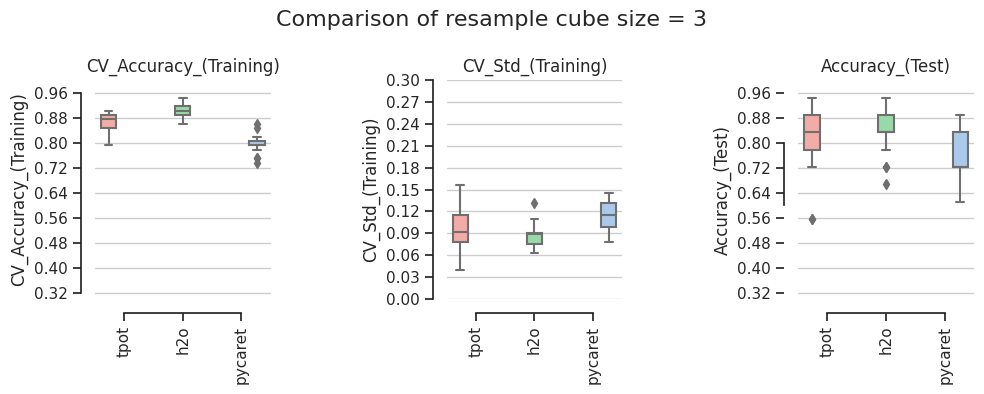

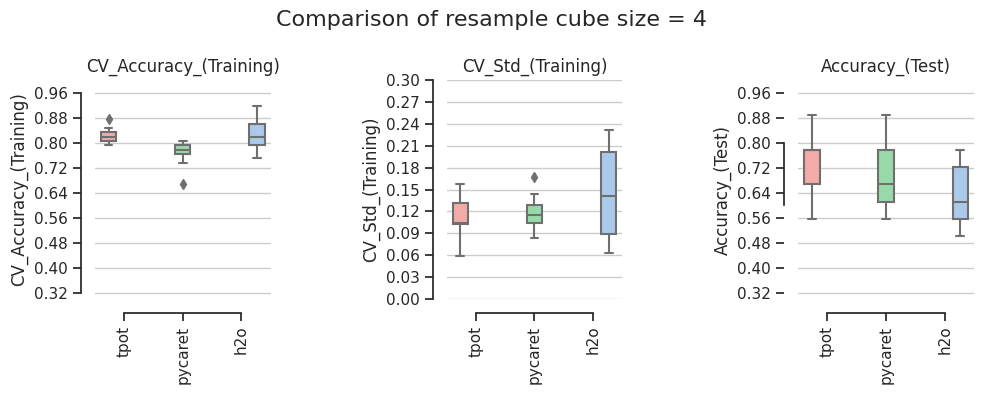

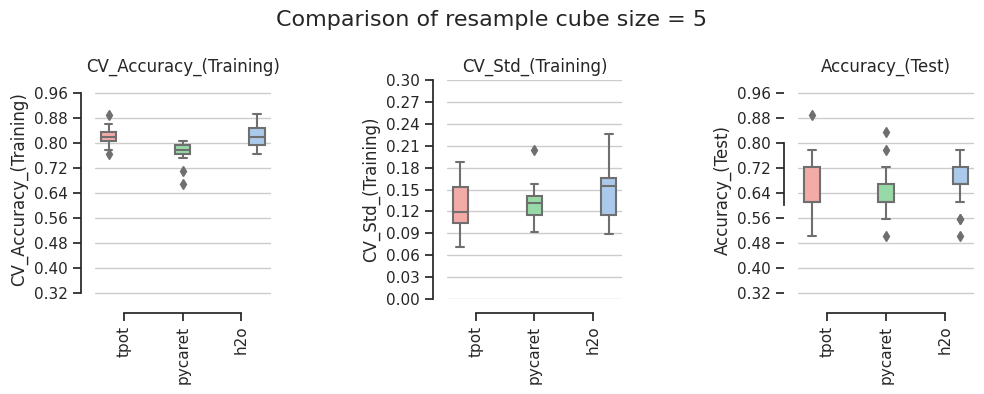

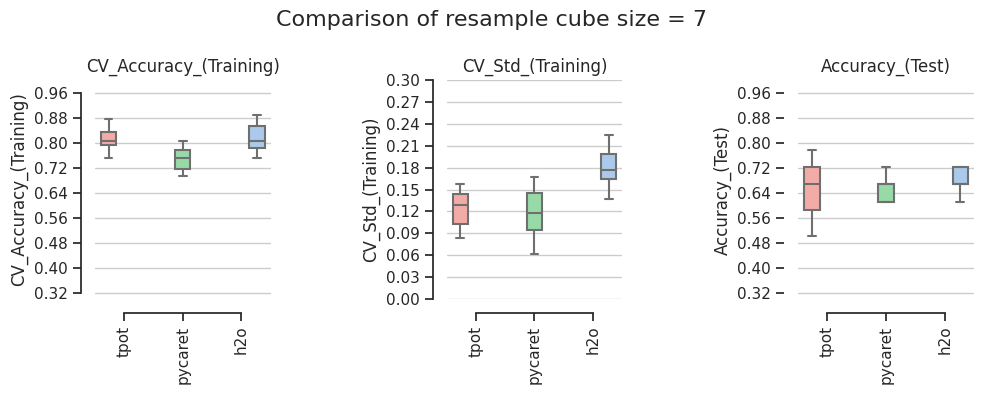

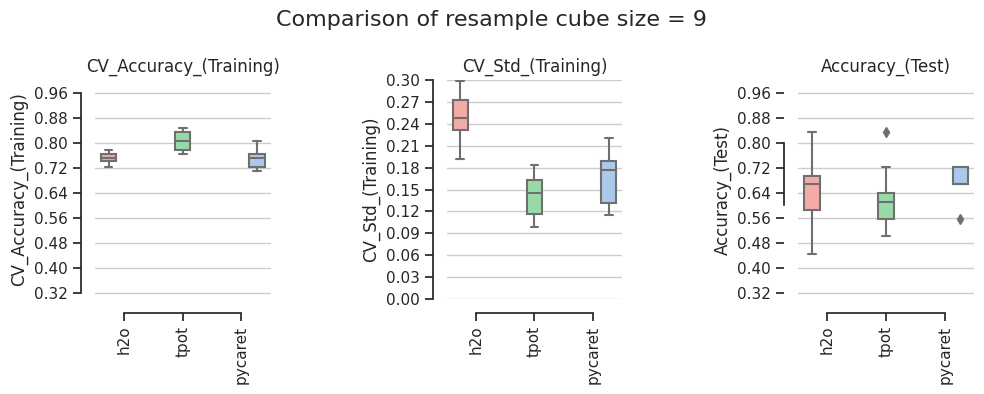

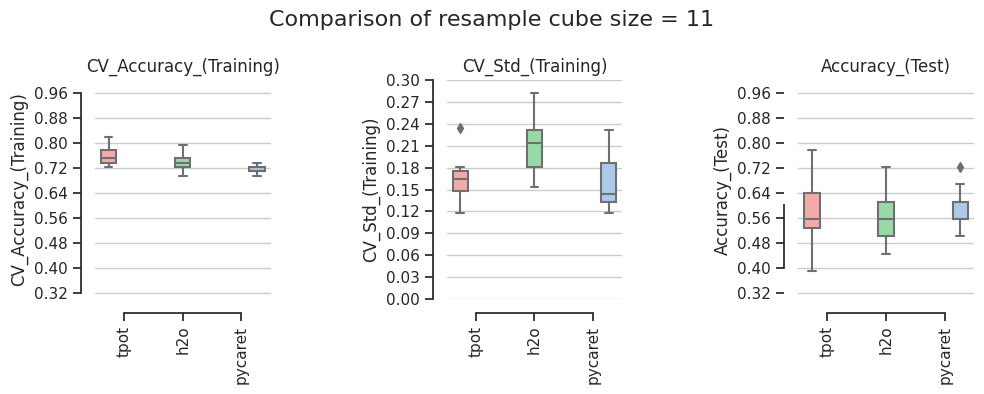

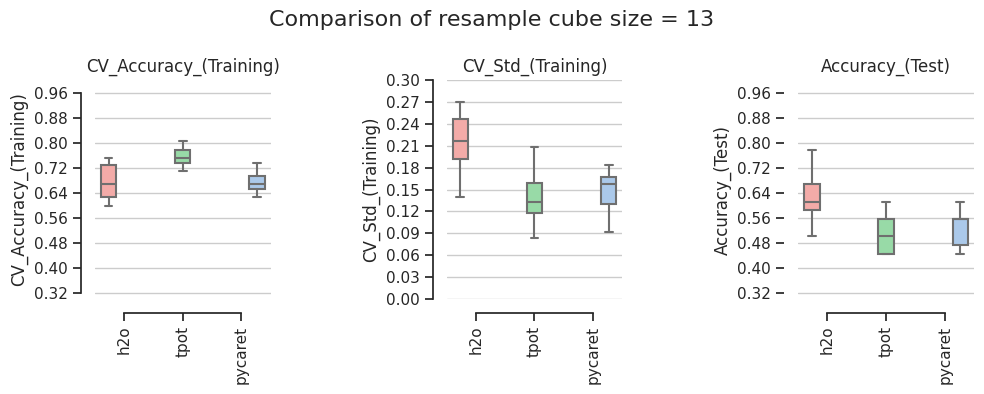

In [116]:
for c in [1, 2, 3, 4, 5, 7, 9, 11, 13]:
    df1 = df_no_param_dup.loc[df_no_param_dup['resample_cube'] == c, :]

    plot_columns = ["CV_Accuracy_(Training)", "CV_Std_(Training)", "Accuracy_(Test)"]

    num_columns = len(plot_columns)
    num_rows = 1
    num_cols = int(np.ceil(num_columns / num_rows))

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4))

    # Flatten the axes array to make it easier to loop through
    flat_axes = axes.flatten()

    for i, col in enumerate(plot_columns):
        sns.boxplot(data=df1, y=col, x="tool",
                    hue="tool", palette=["r", "g", "b"],
                    ax=flat_axes[i])
        flat_axes[i].set_title(col)
        flat_axes[i].yaxis.grid(True)
        # flat_axes[i].set_ylim(0, 1)
        sns.despine(offset=10, trim=True)
        
        # Remove the legend for all subplots except the last one
        # if i != num_columns - 1:
        #     flat_axes[i].get_legend().remove()
        # else:
        #     # Place the legend outside the last subplot on the right side
        #     flat_axes[i].legend(bbox_to_anchor=(1.2, 0.5), loc='upper left', borderaxespad=0.)

        flat_axes[i].set_xlabel("")
        flat_axes[i].tick_params(axis='x', rotation=90)
        flat_axes[i].get_legend().remove()

        # set y-axis limits
        if col == "CV_Accuracy_(Training)":
            flat_axes[i].set_ylim(0.3, 1)
        elif col == "CV_Std_(Training)":
            flat_axes[i].set_ylim(0, 0.3)
        elif col == "Accuracy_(Test)":
            flat_axes[i].set_ylim(0.3, 1)

        # add more ticks to the y-axis
        flat_axes[i].yaxis.set_major_locator(plt.MaxNLocator(11))


    # Remove any unused axes
    for j in range(i+1, num_rows * num_cols):
        flat_axes[j].set_visible(False)

    fig.suptitle(f"Comparison of resample cube size = {c}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(wspace=1)

    # plt.savefig(f"../figures/comparison_RC{c}.svg", format="svg", bbox_inches="tight", pad_inches=0.05)

    plt.show()  

### elbow plots

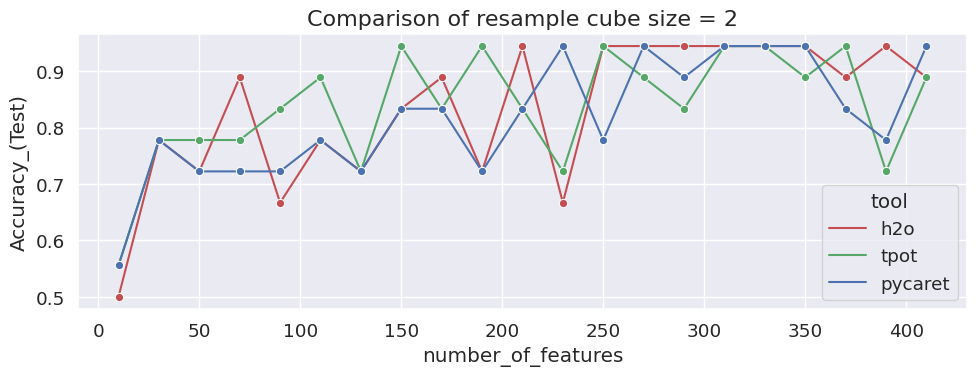

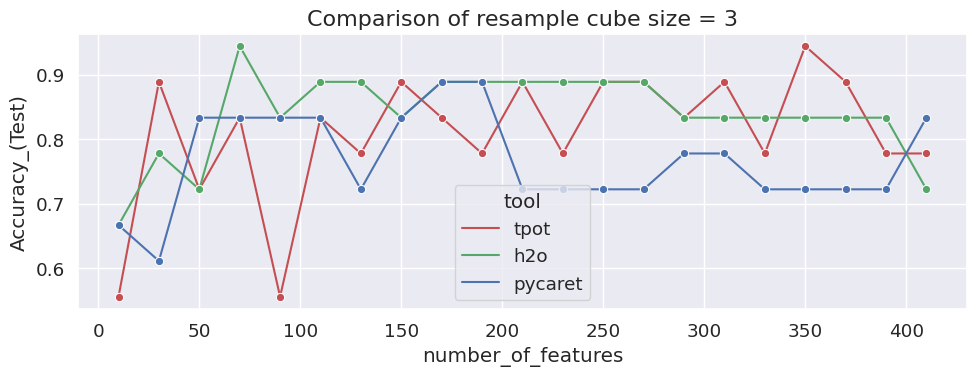

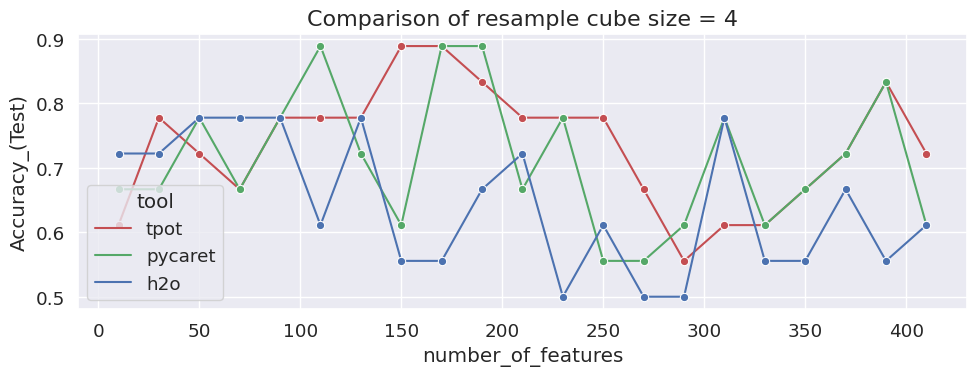

In [89]:
for i, c in enumerate([2, 3, 4]):
    df2 = df_no_param_dup.loc[df_no_param_dup['resample_cube'] == c, :]

    fig, ax = plt.subplots(figsize=(10, 4))

    sns.lineplot(data=df2, x="number_of_features", y="Accuracy_(Test)", 
                 hue="tool", palette=["r", "g", "b"], marker="o")
    
    # set title
    ax.set_title(f"Comparison of resample cube size = {c}", fontsize=16)
    plt.tight_layout()
    plt.show()  

### mean elbow plot

/tmp/ipykernel_20539/2942208588.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=df_grouped, x="number_of_features", y="Accuracy_(Test)_percentage",


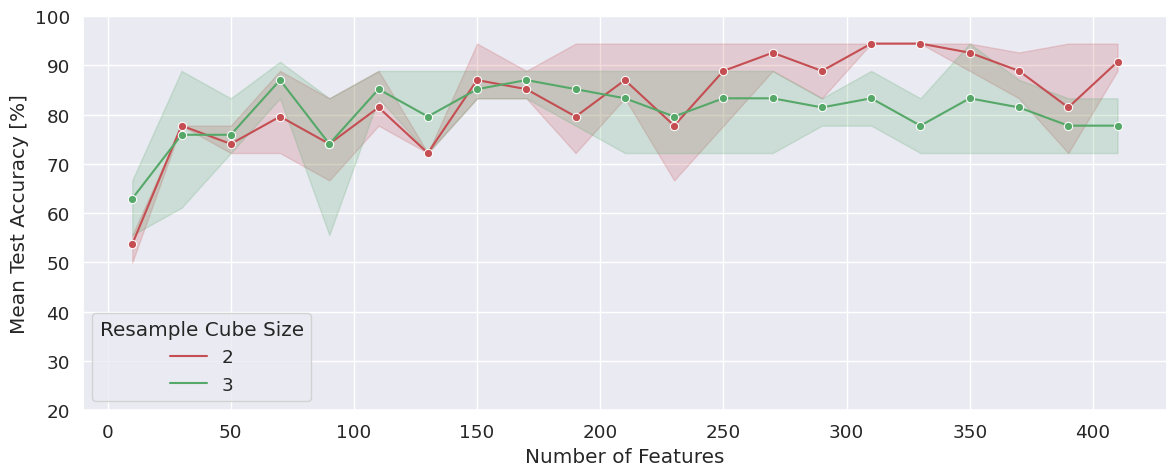

In [99]:
fig, ax = plt.subplots(figsize=(12, 5))

# create new dataframe from df_grouped with only resmaple_cube == 2, 3 or 4
df_grouped = df_no_param_dup.loc[df_no_param_dup['resample_cube'].isin([2, 3]), :].copy()

# create a new column where the Accuracy_(Test) are in percentage
df_grouped['Accuracy_(Test)_percentage'] = df_grouped['Accuracy_(Test)'] * 100

sns.lineplot(data=df_grouped, x="number_of_features", y="Accuracy_(Test)_percentage", 
                hue="resample_cube", palette=["r", "g", "b"], marker="o")

# set title
ax.set_ylabel("Mean Test Accuracy [%]")
ax.set_xlabel("Number of Features")
ax.set_ylim(20, 100)
plt.tight_layout()

# set legend title 
ax.legend(title="Resample Cube Size")

plt.savefig(f"../figures/elbow_mean.svg", format="svg", bbox_inches="tight", pad_inches=0.05)
plt.show()  

## Wilcoxon-test

In [101]:
# lead the csv with the randomized results
df_random = pd.read_csv("../results/results_randomized.csv")

randomized_metrics_summary = df_random.describe().loc[['mean', 'std']]
print(randomized_metrics_summary)

      component  resample_cube  number_of_features  CV_Accuracy_(Training)   
mean        1.0            3.0                70.0                0.663887  \
std         0.0            0.0                 0.0                0.083862   

      CV_Std_(Training)  Accuracy_(Test)  F1_Score_(Test)   
mean           0.159120         0.518513         0.477167  \
std            0.045017         0.118160         0.142822   

      Precision_Score_(Test)  
mean                 0.48724  
std                  0.16313  


In [102]:
df_real = df.loc[(df["resample_cube"] == 3) & (df["number_of_features"] == 70), :].copy()
df_real = df_no_param_dup.loc[(df_no_param_dup["resample_cube"] == 3) & (df_no_param_dup["number_of_features"] == 70), :].copy()

real_metrics_summary = df_real.describe().loc[['mean', 'std']]
print(real_metrics_summary)

      component  resample_cube  number_of_features  CV_Accuracy_(Training)   
mean        1.0            3.0                70.0                0.844567  \
std         0.0            0.0                 0.0                0.051600   

      CV_Std_(Training)  Accuracy_(Test)  F1_Score_(Test)   
mean           0.114067         0.870333         0.869967  \
std            0.017954         0.064144         0.064375   

      Precision_Score_(Test)  
mean                0.875000  
std                 0.064952  


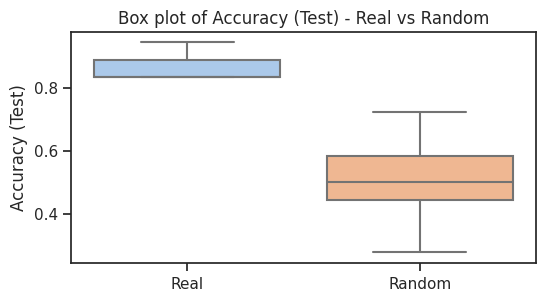

In [103]:
data = [df_real['Accuracy_(Test)'], df_random['Accuracy_(Test)']]
labels = ['Real', 'Random']

plt.figure(figsize=(6,3))
sns.boxplot(data=data)
plt.xticks(range(2), labels)
plt.ylabel('Accuracy (Test)')
plt.title('Box plot of Accuracy (Test) - Real vs Random')
plt.show()

In [106]:
t_stat, p_value = mannwhitneyu(df_real['Accuracy_(Test)'], df_random['Accuracy_(Test)'])
print(f"p-value = {p_value}")

p-value = 0.00851628303493222


/tmp/ipykernel_20539/736395599.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_real['Accuracy_(Test)'], label='Actual', shade=True)
/tmp/ipykernel_20539/736395599.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_random['Accuracy_(Test)'], label='Random', shade=True)


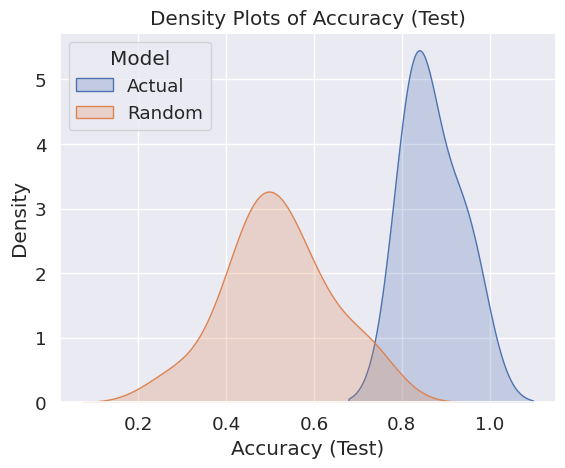

In [97]:
sns.kdeplot(df_real['Accuracy_(Test)'], label='Actual', shade=True)
sns.kdeplot(df_random['Accuracy_(Test)'], label='Random', shade=True)

plt.xlabel('Accuracy (Test)')
plt.ylabel('Density')
plt.title('Density Plots of Accuracy (Test)')
plt.legend(title='Model', loc='upper left')
plt.show()

## 3d best marked and printed

Top 1: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 370, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 350, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 150, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 190, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 30, resample_cube = 5, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 310, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 210, resample_cube = 3, Accuracy_(Test) = 0.8889


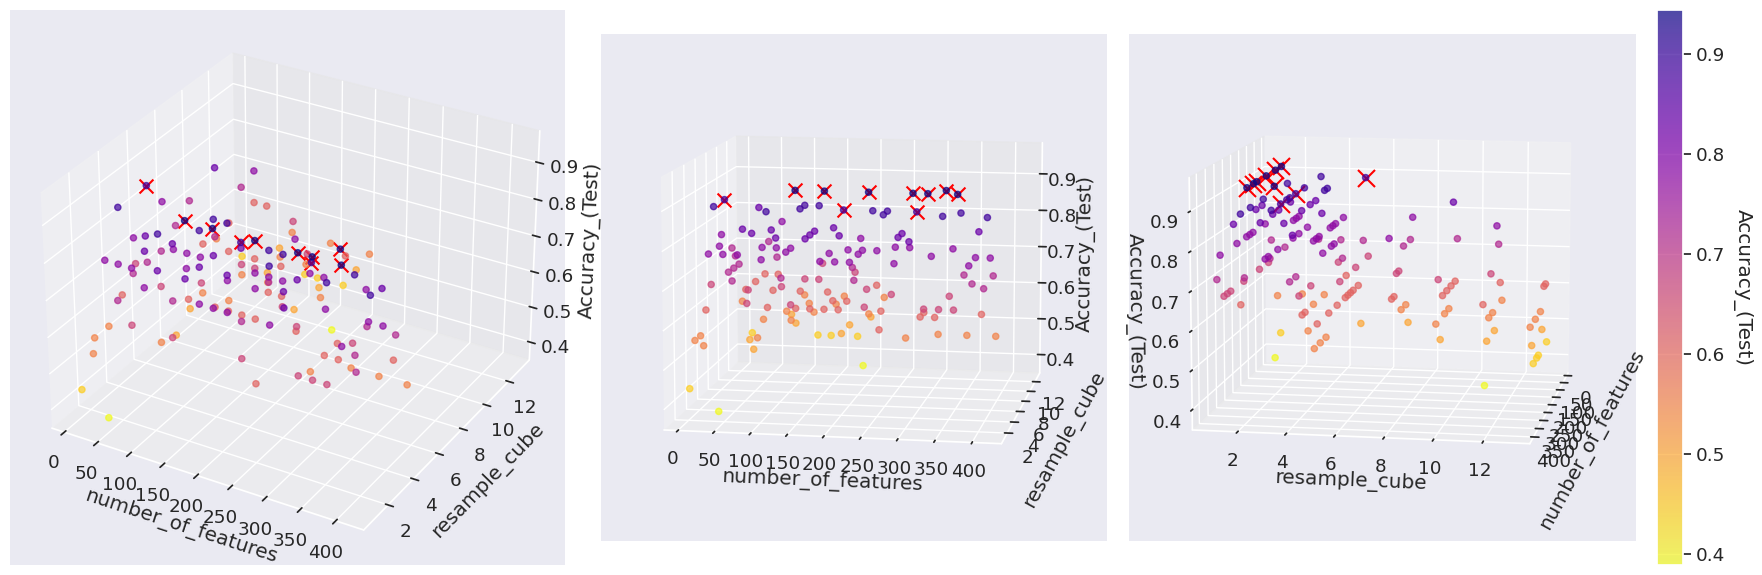

Top 1: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 230, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 190, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 8: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 110, resample_cube = 4, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 190, resample_cube = 4, Accuracy_(Test) = 0.8889


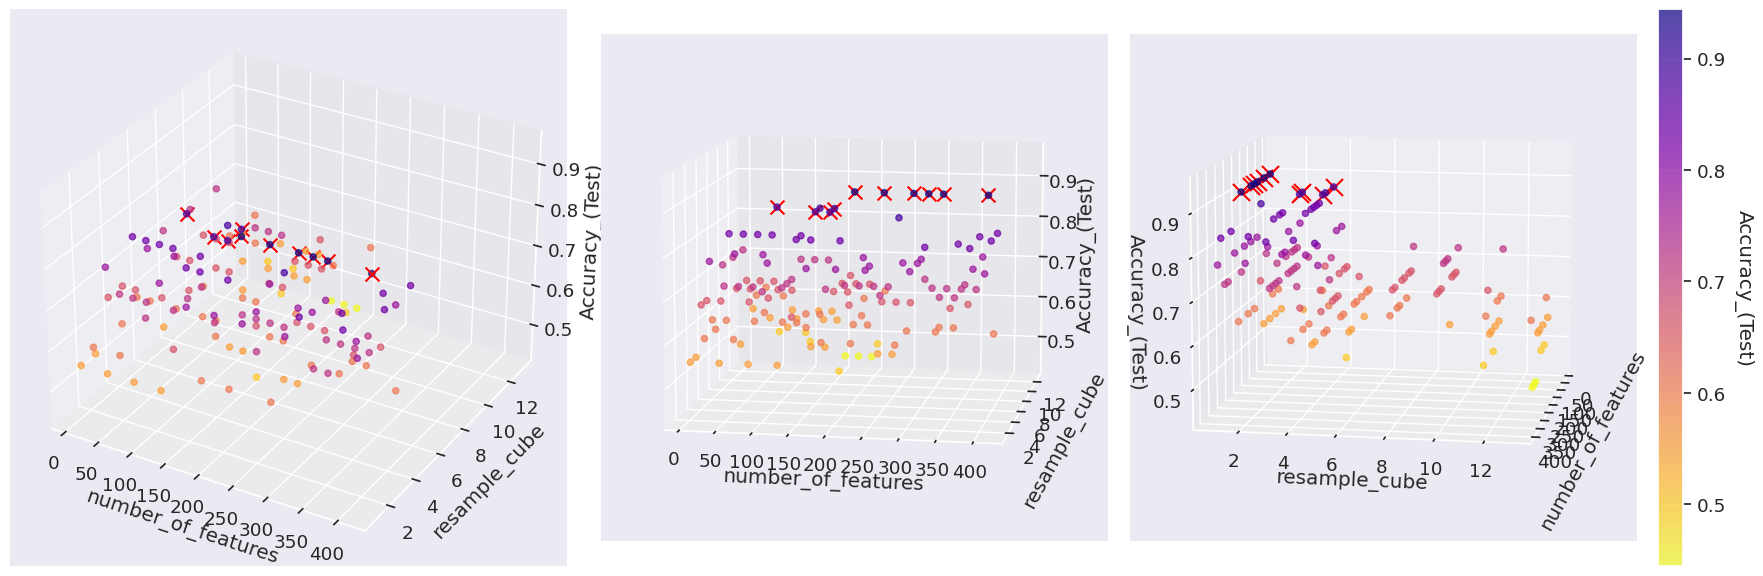

Top 1: number_of_features = 290, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 70, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 210, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 390, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 9: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 10: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.8889


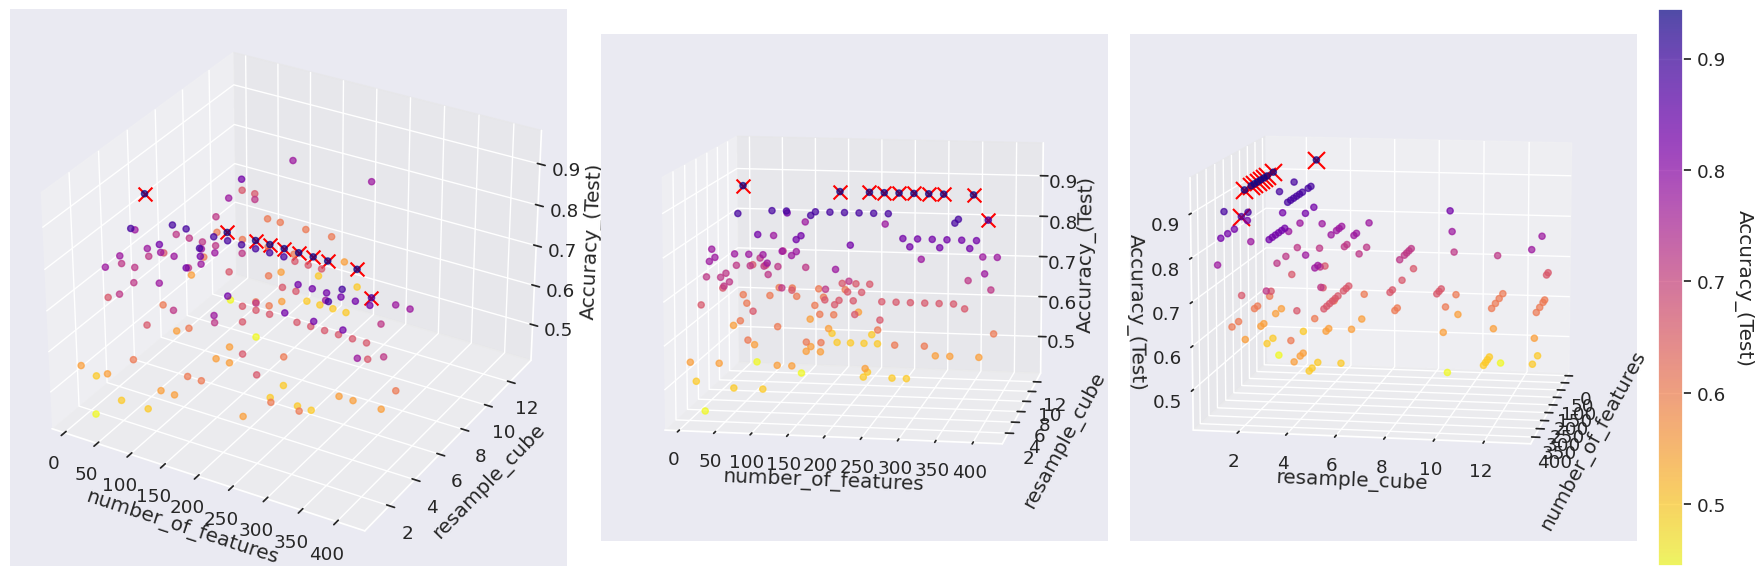

In [59]:
x_best = 10

for df_in_loop in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df_in_loop['number_of_features']
    y = df_in_loop['resample_cube']
    z = df_in_loop['Accuracy_(Test)']

    # Find the top 3 maximum Accuracy_(Test) values and their corresponding x, y, and z coordinates
    top_3_indexes = z.nlargest(x_best).index
    top_3_coordinates = [(x[i], y[i], z[i]) for i in top_3_indexes]

    # Print the best parameters and the maximum accuracy for the top 3
    for i, (x_value, y_value, z_value) in enumerate(top_3_coordinates, start=1):
        print(f"Top {i}: number_of_features = {x_value}, resample_cube = {y_value}, Accuracy_(Test) = {z_value}")

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2.3, 2, 2, 0.1])

    # First subplot (3D view)
    ax1 = fig.add_subplot(gs[0], projection='3d')
    scatter1 = ax1.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    for x_value, y_value, z_value in top_3_coordinates:
        ax1.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Second subplot (projection along the z-axis)
    ax2 = fig.add_subplot(gs[1], projection='3d')
    scatter2 = ax2.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax2.view_init(elev=10, azim=-80)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax2.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Third subplot (projection along the y-axis)
    ax3 = fig.add_subplot(gs[2], projection='3d')
    scatter3 = ax3.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax3.view_init(elev=10, azim=10)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax3.scatter(x_value, y_value, z_value, c='red', marker='x', s=150)

    # Add axis labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter1, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()

# TODO: eventually reverse the axis so that the points are more visible 
# TODO: add a mean surface to the plot

## 3d best marked and printed + surface edges

Top 1: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 370, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 350, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 150, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 190, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 30, resample_cube = 5, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 310, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 210, resample_cube = 3, Accuracy_(Test) = 0.8889


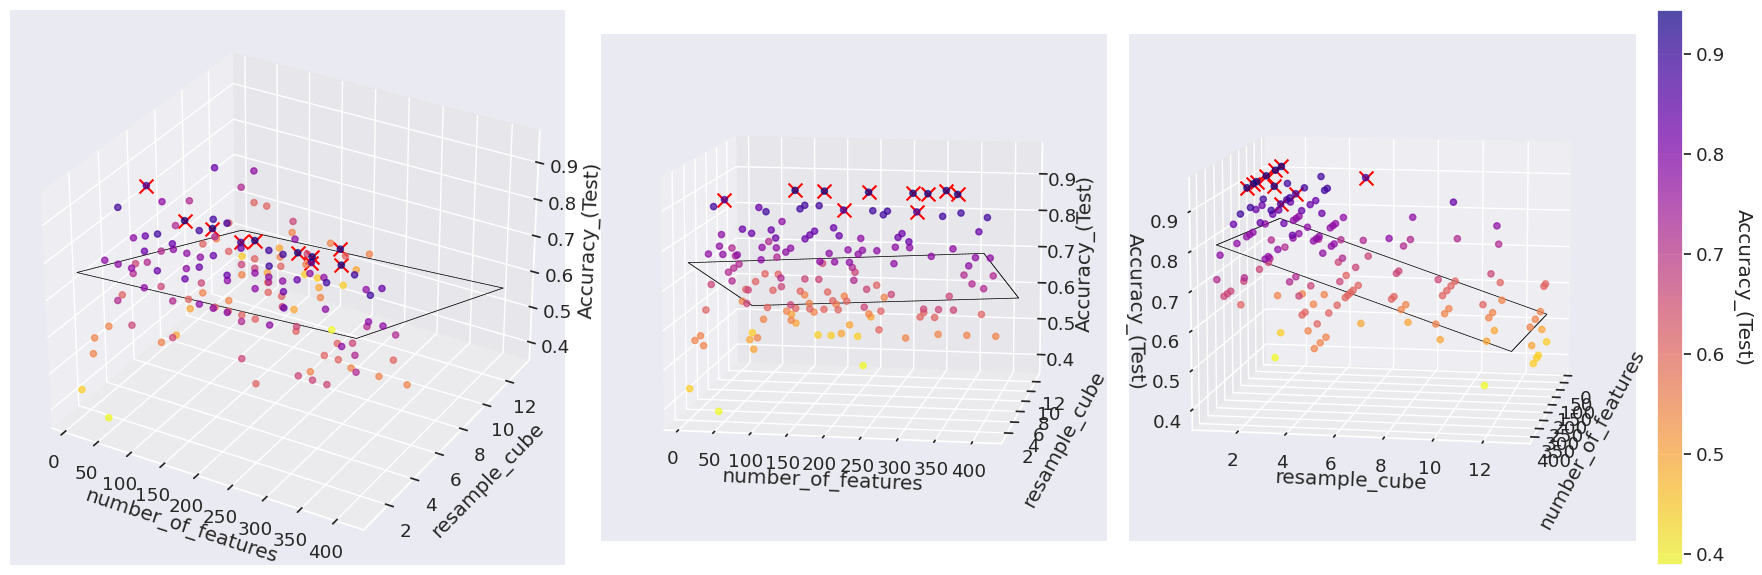

Top 1: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 230, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 190, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 8: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 9: number_of_features = 110, resample_cube = 4, Accuracy_(Test) = 0.8889
Top 10: number_of_features = 190, resample_cube = 4, Accuracy_(Test) = 0.8889


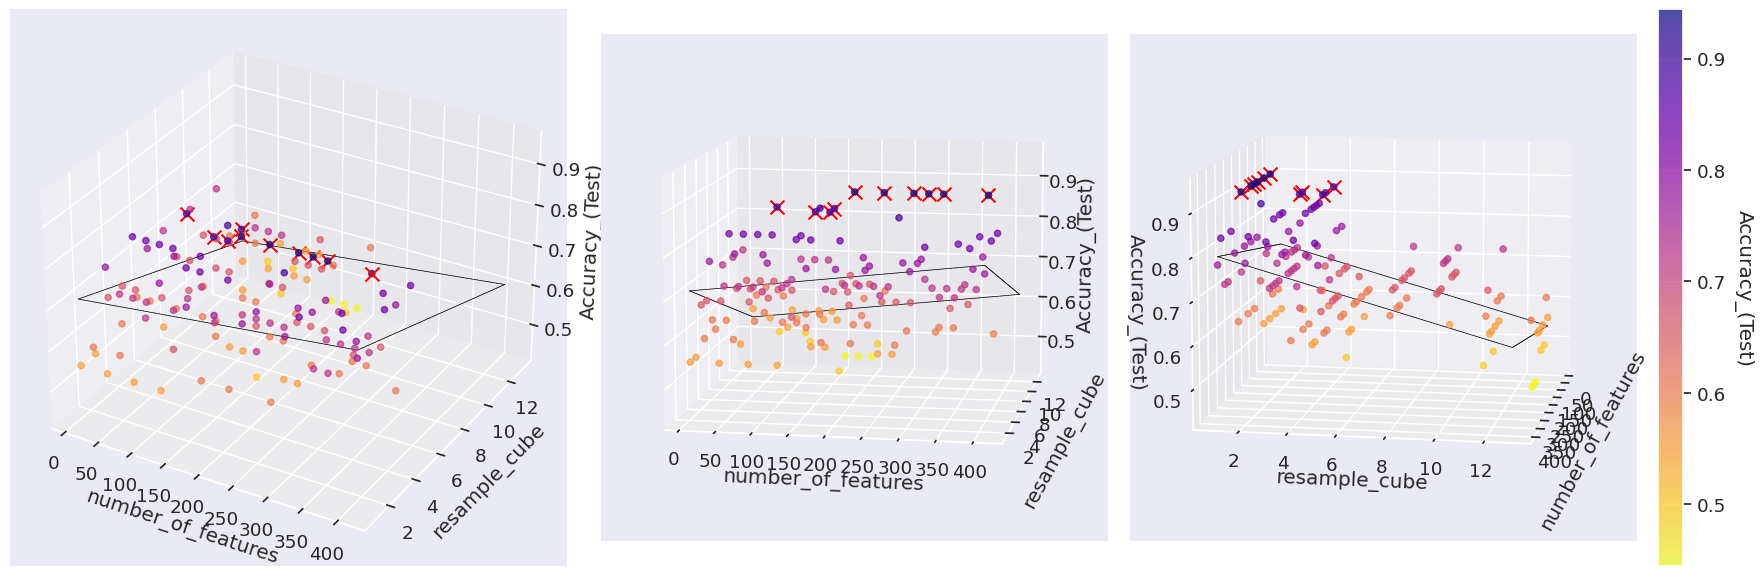

Top 1: number_of_features = 290, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 70, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 3: number_of_features = 210, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 4: number_of_features = 390, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 5: number_of_features = 350, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 6: number_of_features = 330, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 7: number_of_features = 310, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 8: number_of_features = 270, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 9: number_of_features = 250, resample_cube = 2, Accuracy_(Test) = 0.9444
Top 10: number_of_features = 410, resample_cube = 2, Accuracy_(Test) = 0.8889


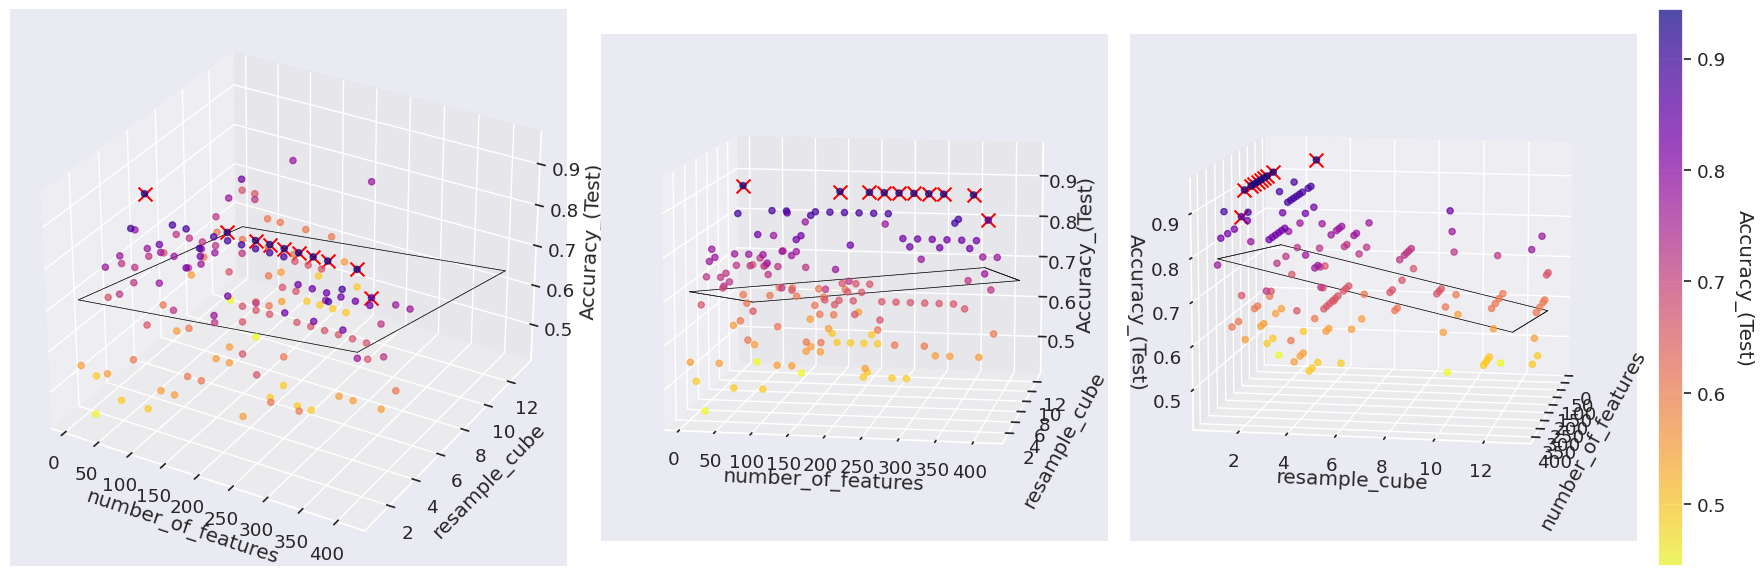

In [60]:
x_best = 10

for df_in_loop in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df_in_loop['number_of_features']
    y = df_in_loop['resample_cube']
    z = df_in_loop['Accuracy_(Test)']

    # Find the top 3 maximum Accuracy_(Test) values and their corresponding x, y, and z coordinates
    top_3_indexes = z.nlargest(x_best).index
    top_3_coordinates = [(x[i], y[i], z[i]) for i in top_3_indexes]

    # Print the best parameters and the maximum accuracy for the top 3
    for i, (x_value, y_value, z_value) in enumerate(top_3_coordinates, start=1):
        print(f"Top {i}: number_of_features = {x_value}, resample_cube = {y_value}, Accuracy_(Test) = {z_value}")

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2.3, 2, 2, 0.1])

    # Generate the grid for interpolation
    x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))

    # 2D linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(np.column_stack((x, y)), z)
    z_grid = lin_reg.predict(np.column_stack((x_grid.ravel(), y_grid.ravel()))).reshape(x_grid.shape)

    for index, view_angle in enumerate([(30, -60), (10, -80), (10, 10)]):

        # Create a 3D scatter plot
        ax = fig.add_subplot(gs[index], projection='3d')
        scatter = ax.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)

        # Plot the top 3 accuracy values
        for x_value, y_value, z_value in top_3_coordinates:
            ax.scatter(x_value, y_value, z_value, c='red', marker='x', linewidth=1.5, s=100)

        # Plot the outer edges of the surface in black
        # Horizontal lines (front and back)
        for i in [0, -1]:
            for j in range(z_grid.shape[1] - 1):
                ax.plot(x_grid[i, j:j+2], y_grid[i, j:j+2], z_grid[i, j:j+2], color='black', linewidth=0.5)

        # Vertical lines (left and right)
        for i in [0, -1]:
            for j in range(z_grid.shape[0] - 1):
                ax.plot(x_grid[j:j+2, i], y_grid[j:j+2, i], z_grid[j:j+2, i], color='black', linewidth=0.5)

        # Set the view angle
        ax.view_init(*view_angle)

        # Add axis labels
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()
